#### importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

#### checking if CUDA is available

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f'Using device: {device}')

Using device: cuda


#### define data transformations with normalization

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#### loading the training and testing datasets with normalization using PyTorch

In [ ]:
train_data = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)


#### define data loaders

In [ ]:
train_loader = DataLoader(
    train_data,
    batch_size=100,
    shuffle=True,
    num_workers=1
)

test_loader = DataLoader(
    test_data,
    batch_size=100,
    shuffle=False,
    num_workers=1
)


#### define model architecture

In [ ]:
class CNN(nn.Module):


    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim=1)


model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

#### training function

In [ ]:
def train(num_epochs):

    train_losses = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * data.size(0)

            if batch_idx % 20 == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                      f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        train_losses.append(epoch_loss / len(train_loader.dataset))

    return train_losses

#### test function

In [ ]:
def test():

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Avg loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
          f"({accuracy:.0f}%)\n")

    return test_loss, accuracy

#### training and testing

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303227
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.283817
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.120591
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.969037
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.772094
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.787301
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.786564
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.772105
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.667334
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.730286
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.625943
Train Epoch: 1 [22000/60000 (37%)]	Loss: 1.613075
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.678206
Train Epoch: 1 [26000/60000 (43%)]	Loss: 1.673688
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.660895
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.632331
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.620585
Train Epoch: 1 [34000/60000 (57%)]	Loss: 1.591347
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.598684
Train Epoch: 1 [38000/60000 (63%)]	Loss: 1.629407
Train Epoch

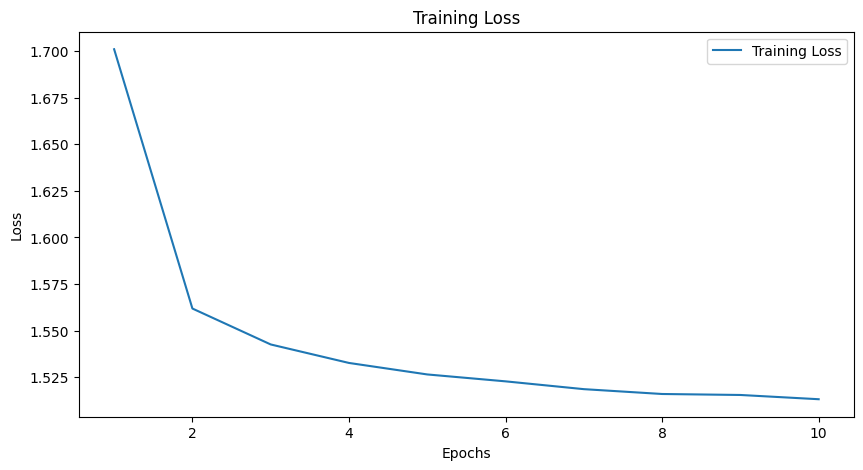

In [ ]:
# main training and testing loop
best_accuracy = 0.0
num_epochs = 10

train_losses = train(num_epochs)
test_loss, accuracy = test()

if accuracy > best_accuracy:
    best_accuracy = accuracy
    torch.save(model.state_dict(), 'best_model.pth')

print(f'Best accuracy on test set: {best_accuracy:.2f}%')

# graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()